<a href="https://colab.research.google.com/github/oaarnikoivu/dissertation/blob/master/GloVe_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch
from torchtext import data

import random
import numpy as np

from pathlib import Path

In [0]:
file_path = '/content/drive/My Drive'

DATA_PATH = Path(file_path + '/datasets/SemEval')
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy', 
                  lower = True, 
                  include_lengths = True)
LABEL = data.LabelField(sequential=False,
                        use_vocab = False,
                        pad_token = None,
                        unk_token = None, 
                        dtype = torch.float)

dataFields = {"Tweet": ("Tweet", TEXT),
              'anger': ("anger", LABEL),
              'anticipation': ("anticipation", LABEL),
              'disgust': ("disgust", LABEL),
              'fear': ("fear", LABEL),
              'joy': ("joy", LABEL),
              'love': ("love", LABEL),
              'optimism': ("optimism", LABEL),
              'pessimism': ("pessimism", LABEL),
              'sadness': ("sadness", LABEL),
              'surprise': ("surprise", LABEL),
              'trust': ("trust", LABEL)}

train_data, valid_data, test_data = data.TabularDataset.splits(
    path = DATA_PATH,
    train = 'train.csv',
    validation = 'val.csv',
    test = 'test.csv',
    format = 'csv',
    fields = dataFields
)

In [0]:
MAX_VOCAB_SIZE = 10000

TEXT.build_vocab(train_data,
                 max_size=MAX_VOCAB_SIZE,
                 vectors="glove.6B.100d",
                 unk_init=torch.Tensor.normal_)

In [0]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    sort_key = lambda x: len(x.Tweet),
    sort_within_batch = True,
    batch_size = BATCH_SIZE,
    device = device
)

In [0]:
LABEL_COLS = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 
              'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

iaux = 0 

for batch in valid_iterator:
  iaux += 1
  aux = batch
  aux2 = torch.stack([getattr(batch, label) for label in LABEL_COLS])
  if iaux == 20: break

In [110]:
torch.transpose(torch.stack([getattr(aux, label) for label in LABEL_COLS]),0,1)

tensor([[0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0.],
        [1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0.],
        [1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.,

# Build the Model

In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:
class CNN(nn.Module):
  def __init__(self, vocab_size, embedding_dim, n_filters, 
               filter_sizes, output_dim, dropout, pad_idx):
    
    super().__init__()

    self.embedding = nn.Embedding(vocab_size, embedding_dim)

    self.convs = nn.ModuleList([
                                nn.Conv2d(in_channels = 1,
                                          out_channels = n_filters,
                                          kernel_size = (fs, embedding_dim)) 
                                for fs in filter_sizes])
    self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)

    self.dropout = nn.Dropout(dropout)
  
  def forward(self, text):
    text = text.permute(1,0)
    embedded = self.embedding(text)
    embedded = embedded.unsqueeze(1)
    conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
    pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
    cat = self.dropout(torch.cat(pooled, dim = 1))
    return self.fc(cat)

In [0]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [3,3,1]
OUTPUT_DIM = 11
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, 
            FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [208]:
model

CNN(
  (embedding): Embedding(10002, 100)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(3, 100), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(3, 100), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(1, 100), stride=(1, 1))
  )
  (fc): Linear(in_features=300, out_features=11, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [209]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,073,811 trainable parameters


In [210]:
pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.6610, -0.0730,  0.9238,  ..., -0.2256,  0.8148, -0.4405],
        ...,
        [ 0.2501, -0.5645,  1.1328,  ..., -0.4779,  1.1052, -0.0475],
        [ 0.0917,  1.1856, -0.0562,  ..., -0.8436,  1.2962,  0.5990],
        [ 0.4041,  1.6816,  1.3186,  ..., -0.3370,  0.5296, -0.3987]])

In [0]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# Train the Model

In [0]:
import torch.optim as optim

In [0]:
optimizer = optim.Adam(model.parameters())

criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [0]:
from sklearn.metrics import roc_auc_score

In [0]:
def roc_auc(preds, y):
  global var_y
  global var_preds 
  var_y = y
  var_preds = preds
  acc = roc_auc_score(y, preds)
  return acc

In [0]:
def train(model, iterator, optimizer, criterion):

  epoch_loss = 0
  epoch_acc = 0

  model.train()

  preds_list = []
  labels_list = []

  for i, batch in enumerate(iterator):
    
    optimizer.zero_grad()

    tweet, tweet_lengths = batch.Tweet

    predictions = model(tweet).squeeze(1)

    batch_labels = torch.stack([getattr(batch, label) for label in LABEL_COLS])
    batch_labels = torch.transpose(batch_labels, 0, 1)

    loss = criterion(predictions, batch_labels)

    loss.backward()

    optimizer.step()

    preds_list += [torch.sigmoid(predictions).detach().cpu().numpy()]
    labels_list += [batch_labels.cpu().numpy()]

    epoch_loss += loss.item() 
  
  return epoch_loss / len(iterator), roc_auc(np.vstack(preds_list),
                                             np.vstack(labels_list))

In [0]:
def evaluate(model, iterator, criterion):

  epoch_loss = 0
  epoch_acc = 0

  model.eval()

  preds_list = []
  labels_list = []
  epoch_acc = []

  with torch.no_grad():
    
    for batch in iterator:

      tweet, tweet_lengths = batch.Tweet

      predictions = model(tweet).squeeze(1)

      batch_labels = torch.stack([getattr(batch, label) for label in LABEL_COLS])
      batch_labels = torch.transpose(batch_labels, 0, 1)

      loss = criterion(predictions, batch_labels)

      epoch_loss += loss.item()

      preds_list += [torch.sigmoid(predictions).detach().cpu().numpy()]
      labels_list += [batch_labels.cpu().numpy()]

  return epoch_loss / len(iterator), roc_auc(np.vstack(preds_list),
                                             np.vstack(labels_list))

In [0]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [219]:
N_EPOCHS = 5

best_valid_loss = float('inf')

train_history = []
valid_history = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    train_history.append(train_acc)
    valid_history.append(valid_acc)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.479 | Train Acc: 53.90%
	 Val. Loss: 0.450 |  Val. Acc: 68.08%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.416 | Train Acc: 69.69%
	 Val. Loss: 0.378 |  Val. Acc: 76.42%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.367 | Train Acc: 77.24%
	 Val. Loss: 0.360 |  Val. Acc: 79.20%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.340 | Train Acc: 81.22%
	 Val. Loss: 0.351 |  Val. Acc: 80.46%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.317 | Train Acc: 83.90%
	 Val. Loss: 0.347 |  Val. Acc: 81.14%


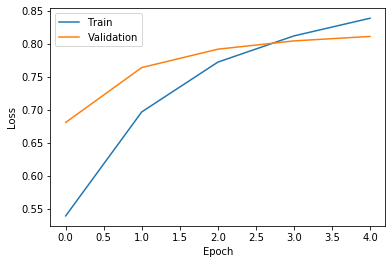

In [220]:
import matplotlib.pyplot as plt

plt.plot(train_history)
plt.plot(valid_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

In [221]:
model.load_state_dict(torch.load('tut4-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.348 | Test Acc: 80.02%


# User Input

In [0]:
import spacy
nlp = spacy.load('en')

tweet = 'I am quite scared of the future, not gonna lie'
tokenized = [tok.text for tok in nlp.tokenizer(tweet)]
indexed = [TEXT.vocab.stoi[t] for t in tokenized]
tensor = torch.LongTensor(indexed).to(device)
tensor = tensor.unsqueeze(1)

In [258]:
tensor.shape

torch.Size([12, 1])

In [259]:
preds = []

with torch.no_grad():
  model.eval()

  torch.cuda.empty_cache()
  
  tweet = tensor
  predictions = model(tweet)
  preds += [torch.sigmoid(predictions).detach().cpu().numpy()]

  torch.cuda.empty_cache()

preds

[array([[0.2194942 , 0.09275133, 0.34991264, 0.9399863 , 0.01192236,
         0.0037441 , 0.03727771, 0.2728653 , 0.6673346 , 0.02698256,
         0.01149845]], dtype=float32)]